# 1. Importing Necessary Libraries

In [3]:
import pandas as pd 
from feature_engine.datetime import DatetimeFeatures

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

from xgboost import XGBRegressor

import joblib
import matplotlib.pyplot as plt

# 2. Display Settings

In [4]:
pd.set_option('display.max_columns', None)
sklearn.set_config(transform_output="default")

# 3. Loading The Data

In [ ]:
train_df = pd.read_csv("Dataset/train.csv")
test_df = pd.read_csv("Dataset/test.csv")

In [6]:
train_df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187
...,...,...,...,...,...,...,...,...,...,...
635,Air Asia,2019-04-12,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info,4282
636,Jet Airways,2019-05-09,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info,13067
637,Indigo,2019-05-15,Banglore,Delhi,06:05:00,08:50:00,165,0.0,No Info,4423
638,Multiple Carriers,2019-05-15,Delhi,Cochin,08:45:00,21:00:00,735,1.0,No Info,7670


# 3.1 Splitting The Data

In [7]:
#define a func. to split the data
def split_data(data):
    X = data.drop(columns=['price'])
    y = data.price.copy()
    return X, y

In [8]:
#splitting of data
X_train, y_train = split_data(train_df)
X_test, y_test = split_data(test_df)
X_val, y_val = split_data(val_df)

# 3.2 Meta Info

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


# 4. Data Preprocessing

In [9]:
# Separate numerical and categorical features
dt_features = ['date_of_journey', 'dep_time', "arrival_time"]
num_features = ['duration', 'total_stops']
cat_features = [col for col in X_train.columns if col not in dt_features + num_features]

In [10]:
# set up the pipeline
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])
doj_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('extractor', DatetimeFeatures(features_to_extract=['month', "week", 'day_of_week', 'day_of_month'], format='mixed')),
    ('scaler', StandardScaler())
]) 
time_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('extractor', DatetimeFeatures(features_to_extract=['hour', 'minute'], format='mixed')),
    ('scaler', StandardScaler())
])

In [11]:
#set up the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features),
        ('doj', doj_transformer, ["date_of_journey"]),
        ("time", time_transformer, ["dep_time", "arrival_time"])
    ]
)

In [15]:
X_pre_data = preprocessor.fit_transform(X_train)

# 5. Model Selection

In [12]:
algorithms = {
    'Linear Regression': LinearRegression(),
    'Support Vector Regressor': SVR(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=10),
    'XGBoost': XGBRegressor(n_estimators=10)
}

In [13]:
#combine the train, val data
data = pd.concat([train_df, val_df], axis=0)

X_data, y_data = split_data(data)

In [14]:
#DEFINE A FUNCTION TO PLOT LEARNING CURVES
def plot_curves(sizes, mean_scores, std_scores, label, ax):
    ax.plot(
        sizes,
        mean_scores,
        marker='o',
        label=label
    )

    ax.fill_between(
        x=sizes,
        y1=mean_scores - std_scores,
        y2=mean_scores + std_scores,
        alpha=0.5
    )

In [15]:
#def the function to plot learning curves
def plot_learning_curves(name, algorithm, figsize=(10, 6)):
    model = Pipeline(steps=[
        ('pre', preprocessor),
        ('alg', algorithm)
    ])

    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=X_data,
        y=y_data,
        cv=3,
        n_jobs=-1,
        scoring='r2',
        random_state=42
    )

    mean_train_scores = train_scores.mean(axis=1)
    mean_test_scores = test_scores.mean(axis=1)

    std_train_scores = train_scores.std(axis=1)
    std_test_scores = test_scores.std(axis=1)
    
    train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"
    test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

    fig, ax = plt.subplots(figsize=figsize)

    #train curves
    plot_curves(
    train_sizes,
    mean_train_scores,
    std_train_scores,
    f"Train ({train_score})",
    ax=ax
    )

    #test curves
    plot_curves(
    train_sizes,
    mean_test_scores,
    std_test_scores,
    f"Test ({test_score})",
    ax=ax
    )

    ax.set(xlabel="Training Set Size", ylabel="R2 Score", title=name)
    ax.legend()
    plt.show()

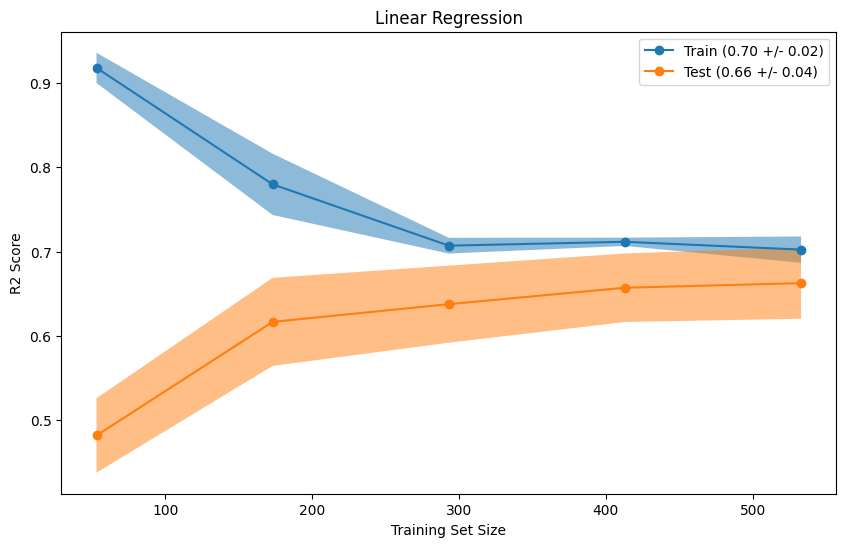

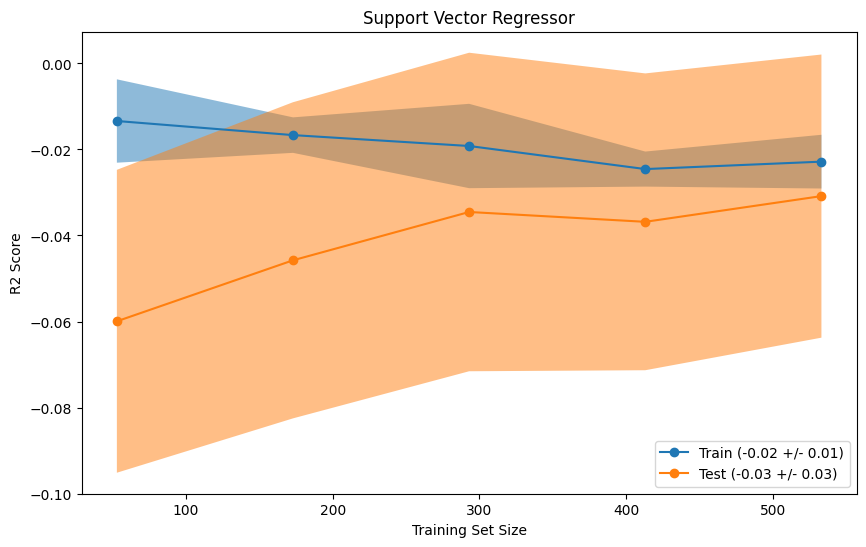

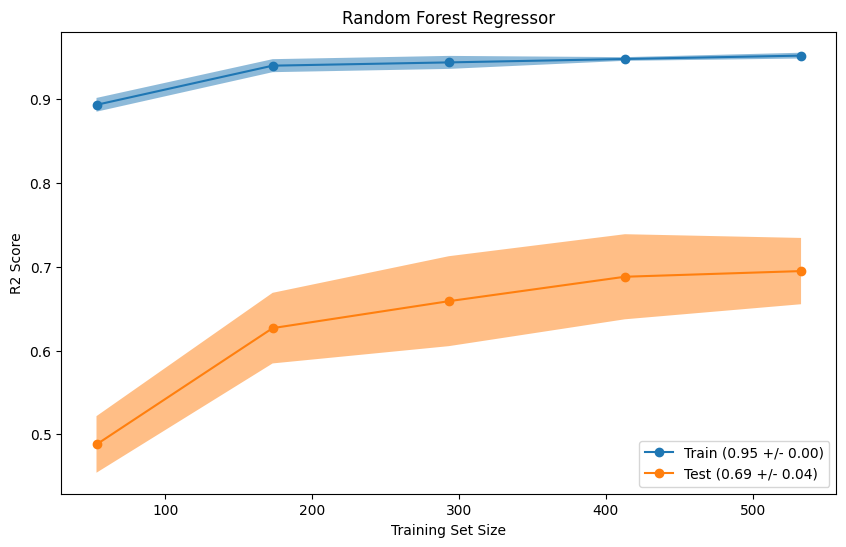

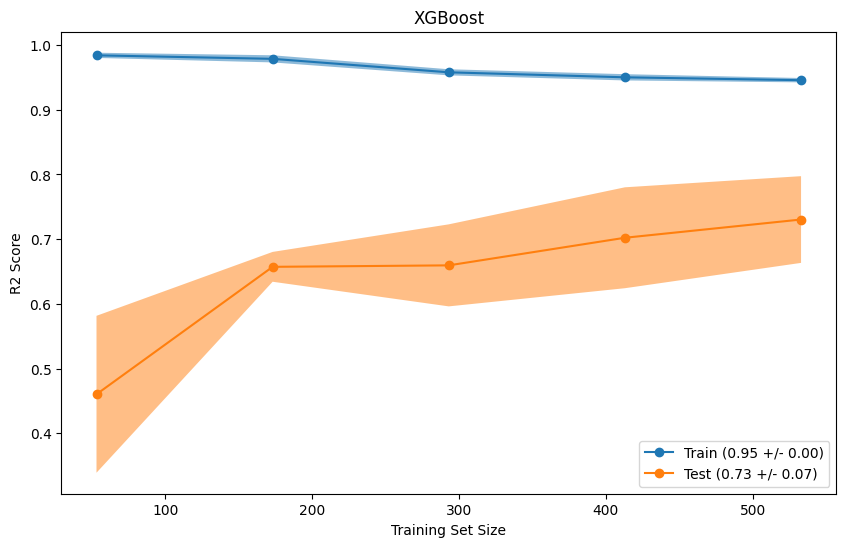

In [16]:
for name, alg in algorithms.items():
    plot_learning_curves(name, alg)

# Model Training

In [17]:
model = Pipeline(steps=[
    ('pre', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=10))
])

In [18]:
model.fit(X_data, y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

# Model Evaluation

In [19]:
def evaluate_model(X, y):
    y_pred = model.predict(X)
    return r2_score(y, y_pred)

In [20]:
print(f"R2 score on training data is {evaluate_model(X_data, y_data)}")

R2 score on training data is 0.9519035093525431


In [21]:
print(f"R2 score on test data is {evaluate_model(X_test, y_test)}")

R2 score on test data is 0.734598389618772


# Model Persistence

In [22]:
joblib.dump(model, 'model.joblib')

['model.joblib']

In [23]:
saved_model = joblib.load('model.joblib')

In [24]:
y_pred = saved_model.predict(X_test)
print(f"R2 score on test data using saved model is {r2_score(y_test, y_pred)}")

R2 score on test data using saved model is 0.734598389618772
